# Partie 1: Chargement de quelques images dans un nouveau repertoire pour l'évaluation des modèles entrainnés

In [1]:
import os
import time
import random
import shutil
import math
import shutil
from skimage import io, color
import cv2
from PIL import Image, ImageFilter
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
import pandas as pd
from torchvision import transforms

In [3]:
# Chemin vers le répertoire contenant les images
chemin_source = '/Users/mohameddiallo/Analyse-de-donnees-et-RL-inverse-pour-la-d-tection-de-biais/ProjetEmmanuelleClaeys/img_align_celeba'

# Chemin vers le nouveau répertoire où je souhaite copier les 2500 images sélectionnées
chemin_destination_parent = '/Users/mohameddiallo/Analyse-de-donnees-et-RL-inverse-pour-la-d-tection-de-biais/ProjetEmmanuelleClaeys'
nom_nouveau_repertoire = 'repertoire_CelebA'

# Nombre d'images à sélectionner
nombre_images_a_selectionner = 2500

# Créer un nouveau répertoire dans le répertoire parent
chemin_destination = os.path.join(chemin_destination_parent, nom_nouveau_repertoire)
if not os.path.exists(chemin_destination):
    os.makedirs(chemin_destination)

# Liste des chemins des fichiers dans le répertoire source
fichiers_source = os.listdir(chemin_source)

# Sélection aléatoire de 2500 images
images_selectionnees = random.sample(fichiers_source, nombre_images_a_selectionner)

# Copier les images sélectionnées dans le nouveau répertoire
for image in tqdm(images_selectionnees,desc="Sélection des images", unit="image"):
    chemin_image_source = os.path.join(chemin_source, image)
    chemin_image_destination = os.path.join(chemin_destination, image)
    shutil.copyfile(chemin_image_source, chemin_image_destination)

print(f"Les {nombre_images_a_selectionner} images ont été copiées avec succès dans le nouveau répertoire :", chemin_destination)


Sélection des images: 100%|█████████████| 2500/2500 [00:04<00:00, 534.32image/s]

Les 2500 images ont été copiées avec succès dans le nouveau répertoire : /Users/mohameddiallo/Analyse-de-donnees-et-RL-inverse-pour-la-d-tection-de-biais/ProjetEmmanuelleClaeys/repertoire_CelebA


# Partie 2: Prédiction de la couleur de peau

In [38]:
# Chemin des dossiers source et destination
source_dir = "/Users/mohameddiallo/Analyse-de-donnees-et-RL-inverse-pour-la-d-tection-de-biais/ProjetEmmanuelleClaeys/repertoire_CelebA"
new_images_dir = "/Users/mohameddiallo/Analyse-de-donnees-et-RL-inverse-pour-la-d-tection-de-biais/ProjetEmmanuelleClaeys/Predict_CelebA"

# Charger le modèle PyTorch pré-entraîné
model = torch.load("/Users/mohameddiallo/Analyse-de-donnees-et-RL-inverse-pour-la-d-tection-de-biais/ProjetEmmanuelleClaeys/code/best_model_resnet101.pth")
model.eval()

# Transformation des images pour l'inférence
transform = transforms.Compose([
    transforms.Resize((256, 256)), # Redimensionner l'image à une taille plus grande pour améliorer la qualité
    transforms.CenterCrop(224), # Recadrer l'image pour garder le centre
    # Appliquer des transformations supplémentaires pour améliorer la netteté et la qualité de l'image
    #transforms.Lambda(lambda img: img.filter(ImageFilter.SHARPEN)), # Filtrage pour améliorer la netteté de l'image
    #transforms.Lambda(lambda img: img.filter(ImageFilter.EDGE_ENHANCE)), # Amélioration des bords à l'image
    #transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Ajustement de la luminosité, du contraste et de la saturation
    transforms.ToTensor(),  # Convertir l'image en tenseur
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normaliser les valeurs de pixel
])

# Fonction pour classifier les nouvelles images
def classify_new_images(source_dir, new_images_dir, model):
    since = time.time()
    # Liste des fichiers dans le dossier source
    source_files = [f for f in os.listdir(source_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp'))]
    
    # Création du dossier pour les nouvelles images si nécessaire
    if not os.path.exists(new_images_dir):
        os.makedirs(new_images_dir)
    
    # Parcours des fichiers dans le dossier source
    for file in tqdm(source_files, desc="Prédiction de la couleur de peau: ", unit="image"):
        # Charger l'image et effectuer la prédiction
        image = Image.open(os.path.join(source_dir, file))
        image_tensor = transform(image).unsqueeze(0)
        output = model(image_tensor)
        _, predicted = torch.max(output, 1)
        
        # Créer un sous-dossier pour la classe prédite si nécessaire
        predicted_class_dir = os.path.join(new_images_dir, str(predicted.item()))
        if not os.path.exists(predicted_class_dir):
            os.makedirs(predicted_class_dir)
        
        # Déplacer l'image dans le sous-dossier de la classe prédite
        shutil.move(os.path.join(source_dir, file), os.path.join(predicted_class_dir, file))
    
    time_elapsed = time.time() - since
    print(f'Classification complète en {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')

# Appel de la fonction
classify_new_images(source_dir, new_images_dir, model)


Prédiction de la couleur de peau: 100%|██| 1562/1562 [06:13<00:00,  4.19image/s]

Classification complète en 6m 13s


# Classification Genre

In [39]:
# Charger le modèle PyTorch pré-entraîné pour l'identification du genre
genre_model = torch.load("best_model_Gender_class.pth")
genre_model.eval()

# Transformation des images pour l'inférence
transform = transforms.Compose([
    transforms.Resize((256, 256)), # Redimensionner l'image à une taille plus grande pour améliorer la qualité
    transforms.CenterCrop(224), # Recadrer l'image pour garder le centre
    # Appliquer des transformations supplémentaires pour améliorer la netteté et la qualité de l'image
    #transforms.Lambda(lambda img: img.filter(ImageFilter.SHARPEN)), # Filtrage pour améliorer la netteté de l'image
    #transforms.Lambda(lambda img: img.filter(ImageFilter.EDGE_ENHANCE)), # Amélioration des bords à l'image
    #transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Ajustement de la luminosité, du contraste et de la saturation
    transforms.ToTensor(),  # Convertir l'image en tenseur
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normaliser les valeurs de pixel
])

# Dossier contenant les images classées par couleur de peau
base_dir = "/Users/mohameddiallo/Analyse-de-donnees-et-RL-inverse-pour-la-d-tection-de-biais/ProjetEmmanuelleClaeys/Predict_CelebA"

# Liste des dossiers (couleurs de peau)
skin_color_folders = [folder for folder in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, folder))]

# Liste pour stocker les informations à sauvegarder dans le CSV
data = []

# Parcours des dossiers de couleur de peau
for skin_color_folder in tqdm(skin_color_folders, desc="Classification du Genre", unit="image"): 
    # Chemin complet du dossier de couleur de peau
    skin_color_path = os.path.join(base_dir, skin_color_folder)
    
    # Liste des fichiers (images) dans le dossier
    image_files = [f for f in os.listdir(skin_color_path) if f.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp'))]
    
    # Parcours des images dans le dossier
    for image_file in image_files:
        # Charger l'image
        image = Image.open(os.path.join(skin_color_path, image_file))
        # Prétraitement de l'image
        image_tensor = transform(image).unsqueeze(0)
        # Prédiction du genre
        output = genre_model(image_tensor)
        _, predicted = torch.max(output, 1)
        
        # Ajouter les informations à la liste de données
        data.append({'image': image_file, 'skin_color': skin_color_folder, 'genre': predicted.item()})

# Convertir la liste de données en DataFrame pandas
df = pd.DataFrame(data)

# Enregistrer le DataFrame dans un fichier CSV
df.to_csv("CelebA_informations_images.csv", index=False)

print("Les informations ont été sauvegardées dans le fichier CSV.")


Classification du Genre: 100%|█████████████████| 5/5 [05:34<00:00, 66.94s/image]

Les informations ont été sauvegardées dans le fichier CSV.


## Tests statistiques

# Exploration des données

In [40]:
import pandas as pd
import seaborn as sns
from ipywidgets import interact
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
import os
from sklearn.metrics import accuracy_score
from scipy.stats import mannwhitneyu, kruskal


In [41]:
data = pd.read_csv('CelebA_informations_images.csv')

In [42]:
# Remplacer les valeurs 0 par "Female" et les valeurs 1 par "Male" dans la colonne 'genre'
data['genre'] = data['genre'].replace({0: 'Female', 1: 'Male'})

In [43]:
# Afficher les premières lignes pour comprendre la structure
data.head()

,image,skin_color,genre
0,041697.jpg,Darkest,Male
1,191461.jpg,Darkest,Male
2,042611.jpg,Darkest,Female
3,183475.jpg,Darkest,Female
4,070932.jpg,Darkest,Female


In [44]:
# Vérifier le nombre de valeurs uniques dans chaque colonne
data.nunique()

image         1562
skin_color       5
genre            2
dtype: int64

In [48]:
df = data.copy()

In [49]:
def effectif_variables(colonne):
    return df[colonne].value_counts().sort_index()

In [50]:
df1 = df.drop(["image"],axis=1)
interact(effectif_variables, colonne=df1);

interactive(children=(Dropdown(description='colonne', options=('skin_color', 'genre'), value='skin_color'), Ou…

In [51]:
def proportion(colonne):
    total = len(df)
    proportion = effectif_variables(colonne) / total
    return proportion

In [52]:
df1 = df.drop(["image"],axis=1)
interact(proportion, colonne=df1);

interactive(children=(Dropdown(description='colonne', options=('skin_color', 'genre'), value='skin_color'), Ou…

In [53]:
def bar_plot(colonne):
    plt.figure(figsize=(12,4))
    
    df[colonne].value_counts().plot(kind='bar') # normalize=True
    plt.ylabel('Proportion')
    plt.xlabel(f'Distribution of {colonne}')
    plt.show()

In [54]:
df1 = df.drop(["image"],axis=1)
interact(bar_plot, colonne=df1);

interactive(children=(Dropdown(description='colonne', options=('skin_color', 'genre'), value='skin_color'), Ou…

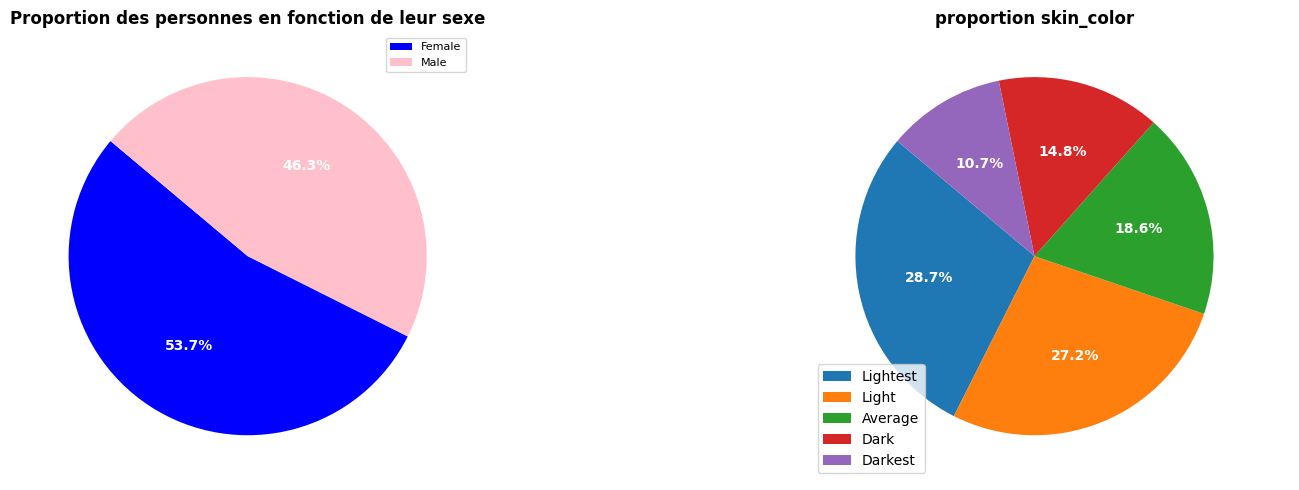

In [55]:
# Etude de proportion par rapport au sexe
sexe_counts = df['genre'].value_counts()
ethinic_counts = df['skin_color'].value_counts()

fig,(ax0, ax1) = plt.subplots(nrows = 1, ncols = 2,figsize=(18, 5))
ax0.pie(sexe_counts, labels=sexe_counts.index, autopct='%1.1f%%', startangle=140, colors=['blue', 'pink'],
       textprops={'color': 'white', 'weight': 'bold'})
ax0.set_title('Proportion des personnes en fonction de leur sexe', fontweight='bold')
ax0.legend(prop={'size':8})

# Etude de proportion par rapport aux skin_colors
ax1.pie(ethinic_counts, labels= ethinic_counts.index, autopct='%1.1f%%', startangle=140,
       textprops={'color': 'white', 'weight': 'bold'})
ax1.set_title('proportion skin_color', fontweight='bold')
ax1.legend(prop={'size':10})


fig.tight_layout()
plt.show()

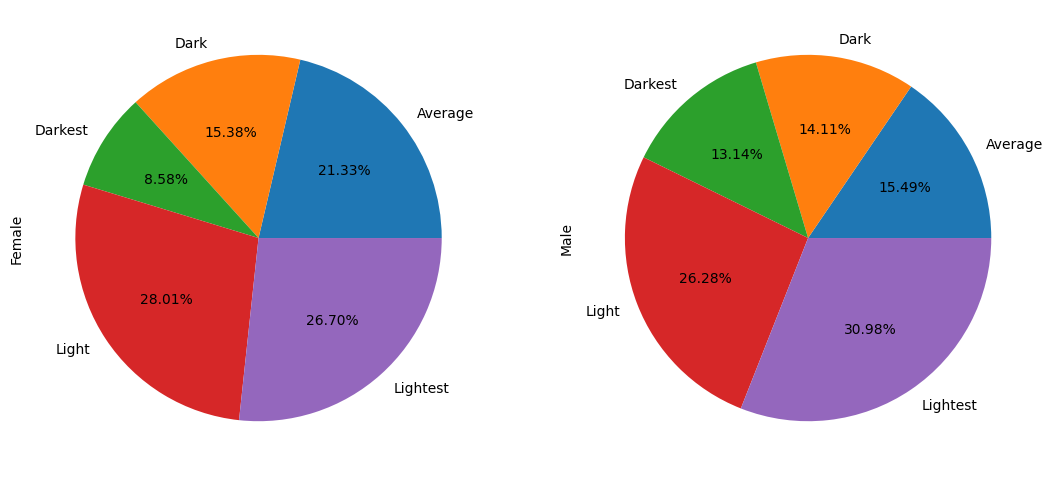

In [56]:
gender_counts = df.groupby('skin_color')['genre'].value_counts().unstack()
gender_counts.plot(kind='pie', subplots=True, figsize=(13, 8), autopct='%2.2f%%',legend=False)
plt.show()

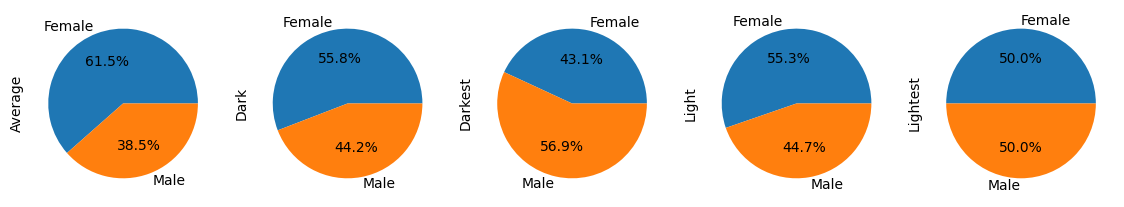

In [57]:
gender_counts = df.groupby('genre')['skin_color'].value_counts().unstack()
gender_counts.plot(kind='pie', subplots=True, figsize=(14, 9), autopct='%1.1f%%',legend=False)

plt.show()

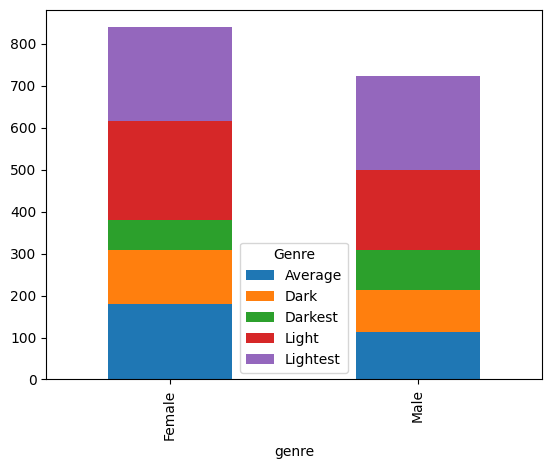

In [58]:
cross_tab = pd.crosstab(df['genre'], df['skin_color'])
stacked_bar = cross_tab.plot(kind='bar', stacked=True)
plt.legend(title='Genre')
plt.show()


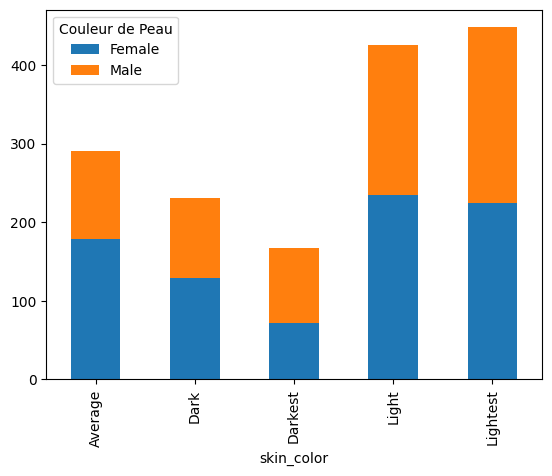

In [59]:
cross_tab = pd.crosstab(df['skin_color'], df['genre'])
stacked_bar = cross_tab.plot(kind='bar', stacked=True)
plt.legend(title='Couleur de Peau')
plt.show()


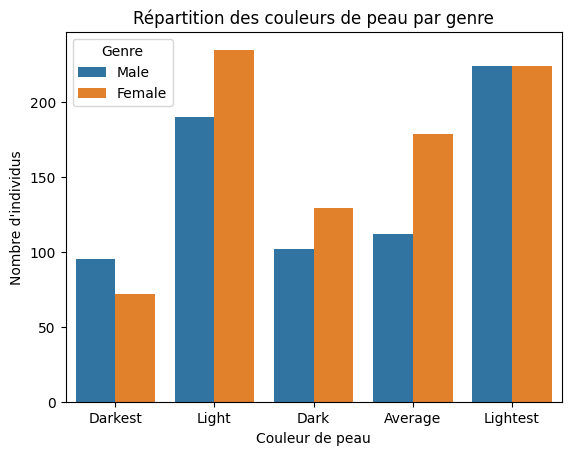

In [60]:
# Répartition des couleurs de peau par genre

sns.countplot(x='skin_color', hue='genre', data=df)
plt.xlabel('Couleur de peau')
plt.ylabel('Nombre d\'individus')
plt.title('Répartition des couleurs de peau par genre')
plt.legend(title='Genre')
plt.show()


# Analyse de la distribution du genre par couleur de peau

Examiner la répartition du genre prédit pour chaque couleur de peau. Cela vous permettra de visualiser les tendances dans les prédictions de genre en fonction de la couleur de peau

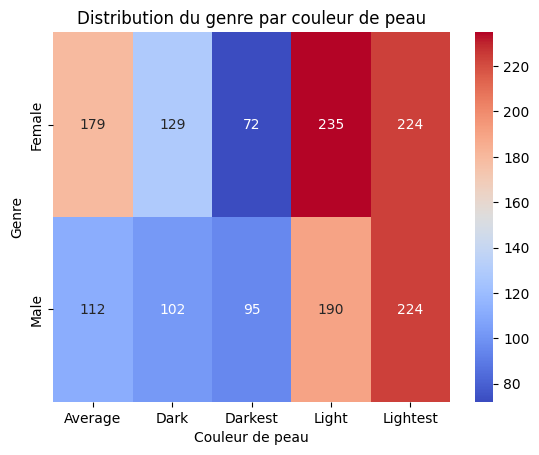

In [61]:
# Créer un tableau croisé du genre par couleur de peau
cross_tab = pd.crosstab(df['genre'], df['skin_color'])

# Visualiser la distribution du genre par couleur de peau
sns.heatmap(cross_tab, annot=True, cmap='coolwarm', fmt='d')
plt.title('Distribution du genre par couleur de peau')
plt.xlabel('Couleur de peau')
plt.ylabel('Genre')
plt.show()

# Étape 2 : Test d'independance

In [66]:
def chi2_test(column1, column2):
    contingency_table = pd.crosstab(data[column1], data[column2])
    chi2, p, _, _ = chi2_contingency(contingency_table)
    print(f"Test du Chi-deux pour {column1} et {column2}:")
    print(f"Chi2 : {chi2}, p-value : {p}")

chi2_test('genre', 'skin_color')

Test du Chi-deux pour genre et skin_color:
Chi2 : 17.999001289075526, p-value : 0.0012346527922144444


Dans ce cas, 17.99 indique une association relativement forte.
Avec une valeur p de 0.0012, nous avons une forte confiance que l'association entre le genre et la couleur de peau n'est pas le résultat du hasard.

En conclusion, sur la base de ce test, nous pouvons affirmer qu'il existe une association significative entre le genre et la couleur de peau dans l'échantillon de données testé. Cela signifie que la distribution des couleurs de peau varie en fonction du genre, ou vice versa, et que cette variation n'est pas due au hasard.

# Calcul du coefficient de V de Cramer

In [67]:
import numpy as np

def cramers_v(chi2, n, r, c):
    """Calcul du coefficient de V de Cramer."""
    return np.sqrt(chi2 / (n * min(r-1, c-1)))

def calculate_cramers_v(chi2, contingency_table):
    """Calcul du coefficient de V de Cramer à partir du Chi2 et du tableau de contingence."""
    n = contingency_table.values.sum()  # Taille de l'échantillon
    r, c = contingency_table.shape  # Nombre de niveaux pour chaque variable
    
    # Calcul du coefficient de V de Cramer
    v_cramer = cramers_v(chi2, n, r, c)
    return v_cramer


chi2_value = 17.9990012890
contingency_table = pd.crosstab(df['genre'], df['genre']) 
v_cramer = calculate_cramers_v(chi2_value, contingency_table)

print(f"Coef. de V de Cramer : {v_cramer}")


Coef. de V de Cramer : 0.10734546194592541


Interprétation :

Les valeurs du coefficient de V de Cramer varient entre 0 et 1. Une valeur proche de 0 indique une faible association, tandis qu'une valeur proche de 1 indique une association forte.

Dans notre cas, avec un coefficient de V de Cramer de 0.107345, cela suggère qu'il y a une faible association entre le genre et la couleur de peau dans l'ensemble de données. Cela signifie que la distribution des couleurs de peau varie légèrement en fonction du genre, mais cette variation est plutôt faible.

En résumé, bien que le test du Chi-deux ait montré une association significative entre le genre et la couleur de peau, le coefficient de V de Cramer indique que cette association est faible. Cela pourrait être dû à plusieurs facteurs, y compris la taille de l'échantillon ou d'autres variables non considérées dans l'analyse.